In [1]:
!set PYTHONPATH=D:\SharedLinux_D\CPSC_597\OCR_Math_Expressions\models\research;D:\SharedLinux_D\CPSC_597\OCR_Math_Expressions\models\research\slim

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import os
import sys
import tensorflow as tf
import zipfile
import cv2
import time
from matplotlib import pyplot as plt
from PIL import Image
import glob
import pandas as pd
import keras
from keras.models import load_model
from keras import backend as K
import lxml.etree as ET
from syntactical_analysis.lexer import Lexer
from syntactical_analysis.parser import Parser
from syntactical_analysis.code_gen import CodeGenerator
from itertools import product
from utils import one_hot_encode_to_char, one_hot_encode_to_char_list
from pprint import pprint
from IPython.display import display, Markdown, Latex
K.set_image_data_format('channels_first')
%matplotlib inline

Using TensorFlow backend.


In [3]:
# turn off tensorflow INFO (Debugging info)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [4]:
OD_PATH = 'models/research/object_detection/'

# append object_detection dir
sys.path.append(OD_PATH+"..")
from object_detection.utils import ops as utils_ops
# od imports
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

In [5]:
# Object Detection Helpers
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
              'num_detections', 'detection_boxes', 'detection_scores',
              'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                 feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
              'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

Faster R-CNN Resent50 Model

In [6]:
# VARIABLES
MODEL_NAME = 'faster_rcnn_resnet50_inference_graph'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = OD_PATH +'faster_rcnn_resnet50_training/'+ MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = OD_PATH + "faster_rcnn_resnet50_training/data/object-detection.pbtxt"

In [7]:
# Load tf model
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

In [8]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

Load CNN model

In [9]:
IMAGE_SIZE = (320, 320)
models_path = "trained_models/"

# CNN
cnn = load_model(models_path+"model3.h5")

# ANN
#ann = load_model(models_path+"ann1.h5")

Syntactical Analysis

In [10]:
lexer = Lexer()
parser = Parser()
codegen = CodeGenerator()

Error Handling before Syntactical Analysis

In [11]:
# used for error handling (symbols with similar features can be interchanged)
similar_maps = [
            (r'\times', 'x', 'X'),
            ('y', 'Y'),
            ('c', r'\subset', r'\subseteq'),
            ('g', '9'),
            ('o', 'O', '0'),
            ('s', '5'),
            ('z', 'Z', '2'),
        ]
greeks = [r'\sigma', r'\Sigma', r'\gamma', r'\delta', r'\Delta',
          r'\eta', r'\theta', r'\epsilon', r'\lambda', r'\mu',
          r'\Pi', r'\rho', r'\phi', r'\omega', r'\ohm']

def get_symbols(syms_):
    result_syms = []
    for i in syms_:
        sym_maps = None
        for j in i:
            #if sym_maps is not None:
            #    break
            # ignore greeks for now since greeks are not included in lexer
            if j[0] in greeks:
                continue
            for k in similar_maps:
                if j[0] in k:
                    sym_maps = k
                    break
            break
        if sym_maps is not None:
            result_syms.append(sym_maps)
        else:
            for j in i:
                if j[0] not in greeks:
                    result_syms.append((j[0],))
                    break
    return result_syms

def generate_eqns(err_handled_symbols):
    return [i for i in product(*err_handled_symbols)]

Load Images

In [12]:
PATH_TO_TEST_IMAGES_DIR = "datasets/object_detection/test/*.png"
PATH_TO_TRAIN_IMAGES_DIR = "datasets/object_detection/train/*.png"
PATH_TO_EVALUATE_IMAGES_DIR = "datasets/object_detection/evaluate/*.png"


TEST_IMAGE_PATHS = list(glob.glob(PATH_TO_TEST_IMAGES_DIR))
TRAIN_IMAGE_PATHS = list(glob.glob(PATH_TO_TRAIN_IMAGES_DIR))
EVALUATE_IMAGE_PATHS = list(glob.glob(PATH_TO_EVALUATE_IMAGES_DIR))


print("Evaluate Image paths: ")
for i in EVALUATE_IMAGE_PATHS:
    print(i)
    
# Change TEST/TRAIN/EVALUATE Images to test here
image_paths = EVALUATE_IMAGE_PATHS
# image_paths = TEST_IMAGE_PATHS
# image_paths = TRAIN_IMAGE_PATHS

Evaluate Image paths: 
datasets/object_detection/evaluate\exp0010.png
datasets/object_detection/evaluate\exp0016.png
datasets/object_detection/evaluate\exp0020.png
datasets/object_detection/evaluate\exp0025.png
datasets/object_detection/evaluate\exp0027.png
datasets/object_detection/evaluate\exp0030.png
datasets/object_detection/evaluate\exp0035.png
datasets/object_detection/evaluate\exp0039.png
datasets/object_detection/evaluate\exp0042.png
datasets/object_detection/evaluate\exp0053.png


In [13]:
symbols = pd.read_csv("processed_data/symbols.csv").drop(["Unnamed: 0"], axis=1)

def get_symbol_from_id(id_):
    return symbols[symbols['new_id']==id_].latex.values[0]

In [14]:
%matplotlib inline

-------------------------
Detecting Boxes for Image:  datasets/object_detection/evaluate/exp0010.png
Image shape:  (320, 320, 3)
***************
Box: 
left:  271.9712257385254  right:  299.5462989807129  top:  148.2652759552002  bottom  181.95858001708984
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 91.63 %
Symbol_id: 92 , Latex: \times , Confidence Score: 4.95 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 2.46 %


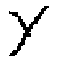

***************
Box: 
left:  16.1465585231781  right:  51.52427673339844  top:  144.76730346679688  bottom  180.4487419128418
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 87.18 %
Symbol_id: 25 , Latex: Z , Confidence Score: 12.51 %


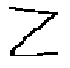

***************
Box: 
left:  198.25593948364258  right:  229.46779251098633  top:  153.28859329223633  bottom  180.55418014526367
CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 88.0 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 9.13 %


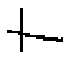

***************
Box: 
left:  77.14836120605469  right:  108.79302978515625  top:  144.83491897583008  bottom  182.0561981201172
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 86.14 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 9.83 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.44 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.1 %


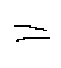

***************
Box: 
left:  131.2384033203125  right:  165.78475952148438  top:  151.21049880981445  bottom  184.5259666442871
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 84.62 %
Symbol_id: 59 , Latex: x , Confidence Score: 11.53 %
Symbol_id: 23 , Latex: X , Confidence Score: 3.57 %


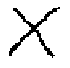

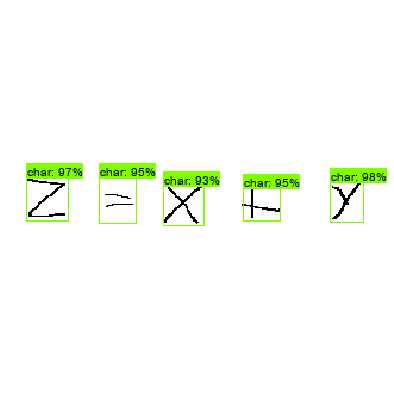

Generated XMLs
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>x</mi><mo>+</mo><mi>y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>x</mi><mo>+</mo><mi>y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>x</mi><mo>+</mo><mi>Y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>x</mi><mo>+</mo><mi>Y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>X</mi><mo>+</mo><mi>y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>X</mi><mo>+</mo><mi>y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>X</mi><mo>+</mo><mi>Y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>X</mi><mo>+</mo><mi>Y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>x</mi><mo>+</mo><mi>y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>x</mi><mo>+</mo><mi>y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>x</mi><mo>+</mo><mi>Y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>x</mi><mo>+</mo><mi>Y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>X</mi><mo>+</mo><mi>y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>X</mi><mo>+</mo><mi>y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>X</mi><mo>+</mo><mi>Y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>X</mi><mo>+</mo><mi>Y</mi></mrow></math>

**********
-------------------------
Detecting Boxes for Image:  datasets/object_detection/evaluate/exp0016.png
Image shape:  (320, 320, 3)
***************
Box: 
left:  258.47320556640625  right:  286.4094352722168  top:  146.97235107421875  bottom  186.5411376953125
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 65.06 %
Symbol_id: 24 , Latex: Y , Confidence Score: 12.61 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.84 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 3.63 %
Symbol_id: 61 , Latex: z , Confidence Score: 3.46 %
Symbol_id: 33 , Latex: 7 , Confidence Score: 2.49 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.46 %
Symbol_id: 92 , Latex: \times , Confidence Score: 1.29 %


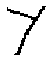

***************
Box: 
left:  16.213520765304565  right:  55.44495105743408  top:  148.40779304504395  bottom  186.40602111816406
CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 93.33 %
Symbol_id: 61 , Latex: z , Confidence Score: 6.22 %


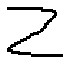

***************
Box: 
left:  69.14685249328613  right:  104.32090759277344  top:  150.2897834777832  bottom  188.40211868286133
CNN/ANN Predictions:
Symbol_id: 83 , Latex: - , Confidence Score: 48.59 %
Symbol_id: 104 , Latex: = , Confidence Score: 22.36 %
Symbol_id: 94 , Latex: \div , Confidence Score: 14.23 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 7.81 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 4.4 %


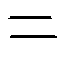

***************
Box: 
left:  188.69874954223633  right:  232.5419807434082  top:  147.65944480895996  bottom  176.43932342529297
CNN/ANN Predictions:
Symbol_id: 96 , Latex: \perp , Confidence Score: 31.84 %
Symbol_id: 19 , Latex: T , Confidence Score: 22.73 %
Symbol_id: 84 , Latex: + , Confidence Score: 16.82 %
Symbol_id: 71 , Latex: \Pi , Confidence Score: 16.27 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.13 %
Symbol_id: 5 , Latex: F , Confidence Score: 2.52 %
Symbol_id: 36 , Latex: \sigma , Confidence Score: 1.46 %
Symbol_id: 89 , Latex: \# , Confidence Score: 1.32 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 1.02 %


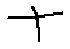

***************
Box: 
left:  126.9401741027832  right:  160.70711135864258  top:  149.95101928710938  bottom  181.9410514831543
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.85 %


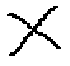

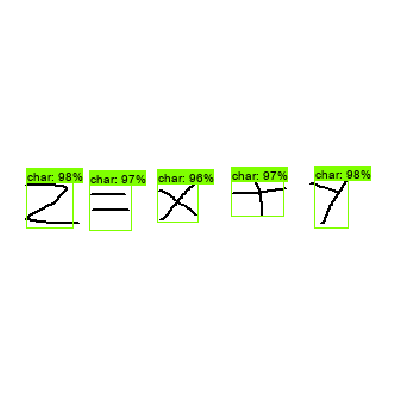

Generated XMLs
-------------------------
Detecting Boxes for Image:  datasets/object_detection/evaluate/exp0020.png
Image shape:  (320, 320, 3)
***************
Box: 
left:  18.442795276641846  right:  53.16028118133545  top:  149.99078750610352  bottom  179.65330123901367
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 94.48 %
Symbol_id: 25 , Latex: Z , Confidence Score: 4.53 %


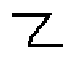

***************
Box: 
left:  269.18701171875  right:  288.8397789001465  top:  151.41783714294434  bottom  189.25176620483398
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 80.99 %
Symbol_id: 24 , Latex: Y , Confidence Score: 18.4 %


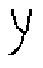

***************
Box: 
left:  73.53553771972656  right:  105.31068801879883  top:  147.03940391540527  bottom  183.11054229736328
CNN/ANN Predictions:
Symbol_id: 75 , Latex: \cdot , Confidence Score: 94.49 %
Symbol_id: 104 , Latex: = , Confidence Score: 3.25 %


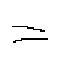

***************
Box: 
left:  133.77123832702637  right:  165.74737548828125  top:  154.71757888793945  bottom  188.5317611694336
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.82 %


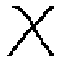

***************
Box: 
left:  196.18928909301758  right:  237.27140426635742  top:  150.03829956054688  bottom  185.71182250976562
CNN/ANN Predictions:
Symbol_id: 83 , Latex: - , Confidence Score: 50.57 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 28.94 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 7.1 %
Symbol_id: 104 , Latex: = , Confidence Score: 5.29 %
Symbol_id: 94 , Latex: \div , Confidence Score: 2.9 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 1.86 %
Symbol_id: 68 , Latex: \epsilon , Confidence Score: 1.27 %


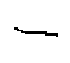

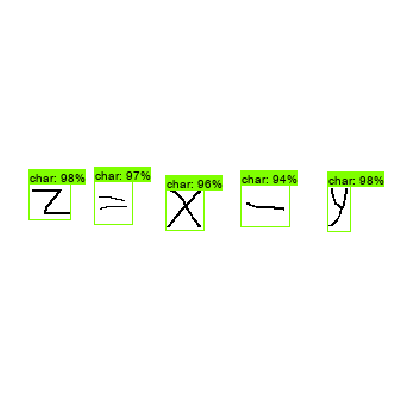

Generated XMLs
-------------------------
Detecting Boxes for Image:  datasets/object_detection/evaluate/exp0025.png
Image shape:  (320, 320, 3)
***************
Box: 
left:  263.4783935546875  right:  296.39429092407227  top:  141.78706169128418  bottom  175.58361053466797
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 94.12 %
Symbol_id: 25 , Latex: Z , Confidence Score: 5.85 %


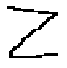

***************
Box: 
left:  17.772464752197266  right:  39.64927673339844  top:  146.58673286437988  bottom  184.24612045288086
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 51.43 %
Symbol_id: 24 , Latex: Y , Confidence Score: 48.0 %


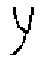

***************
Box: 
left:  204.49758529663086  right:  231.39837265014648  top:  142.78132438659668  bottom  177.0927619934082
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 96.78 %
Symbol_id: 59 , Latex: x , Confidence Score: 3.16 %


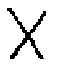

***************
Box: 
left:  69.20857429504395  right:  98.04106712341309  top:  146.52674674987793  bottom  178.52134704589844
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 84.47 %
Symbol_id: 83 , Latex: - , Confidence Score: 5.59 %
Symbol_id: 75 , Latex: \cdot , Confidence Score: 4.87 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.76 %
Symbol_id: 94 , Latex: \div , Confidence Score: 1.43 %


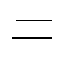

***************
Box: 
left:  128.93500328063965  right:  161.32583618164062  top:  148.4100341796875  bottom  179.36712265014648
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 92.62 %
Symbol_id: 25 , Latex: Z , Confidence Score: 6.15 %


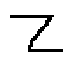

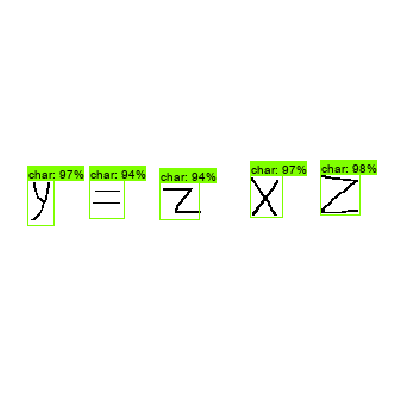

Generated XMLs
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mi>z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mi>z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mi>Z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mi>Z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mn>2</mn></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mn>2</mn></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>zxz</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>zxz</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>zxZ</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>zxZ</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>zXz</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>zXz</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>zXZ</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>zXZ</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mi>z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mi>z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mi>Z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mi>Z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mn>2</mn></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mn>2</mn></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>Zxz</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>Zxz</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>ZxZ</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>ZxZ</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>ZXz</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>ZXz</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>ZXZ</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mi>ZXZ</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mi>z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mi>z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mi>Z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mi>Z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mn>2</mn></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mn>2</mn></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mi>z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mi>z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mi>Z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mi>Z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mn>2</mn></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>z</mi><mo>&#215;</mo><mn>2</mn></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>zxz</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>zxz</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>zxZ</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>zxZ</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>zXz</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>zXz</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>zXZ</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>zXZ</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mi>z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mi>z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mi>Z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mi>Z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mn>2</mn></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>Z</mi><mo>&#215;</mo><mn>2</mn></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>Zxz</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>Zxz</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>ZxZ</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>ZxZ</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>ZXz</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>ZXz</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>ZXZ</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mi>ZXZ</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mi>z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mi>z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mi>Z</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mi>Z</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mn>2</mn></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Y</mi><mo>=</mo><mn>2</mn><mo>&#215;</mo><mn>2</mn></mrow></math>

**********
-------------------------
Detecting Boxes for Image:  datasets/object_detection/evaluate/exp0027.png
Image shape:  (320, 320, 3)
***************
Box: 
left:  154.59269523620605  right:  188.3614158630371  top:  107.13777542114258  bottom  145.16844749450684
CNN/ANN Predictions:
Symbol_id: 38 , Latex: b , Confidence Score: 93.33 %
Symbol_id: 31 , Latex: 5 , Confidence Score: 3.8 %
Symbol_id: 64 , Latex: \delta , Confidence Score: 1.84 %


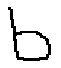

***************
Box: 
left:  253.91778945922852  right:  290.9895133972168  top:  116.93167686462402  bottom  148.91695976257324
CNN/ANN Predictions:
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 69.23 %
Symbol_id: 80 , Latex: \subset , Confidence Score: 22.5 %
Symbol_id: 39 , Latex: c , Confidence Score: 6.74 %
Symbol_id: 2 , Latex: C , Confidence Score: 1.31 %


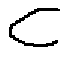

***************
Box: 
left:  214.01288986206055  right:  243.06583404541016  top:  111.87661170959473  bottom  144.5665454864502
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 98.37 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.09 %


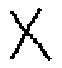

***************
Box: 
left:  11.676771640777588  right:  52.59812831878662  top:  115.43777465820312  bottom  150.49249649047852
CNN/ANN Predictions:
Symbol_id: 37 , Latex: a , Confidence Score: 82.5 %
Symbol_id: 103 , Latex: \ohm , Confidence Score: 14.21 %
Symbol_id: 16 , Latex: Q , Confidence Score: 1.23 %


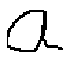

***************
Box: 
left:  73.00946712493896  right:  115.47347068786621  top:  115.36457061767578  bottom  148.05694580078125
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 89.85 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.89 %
Symbol_id: 81 , Latex: \supset , Confidence Score: 2.6 %
Symbol_id: 83 , Latex: - , Confidence Score: 1.52 %


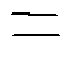

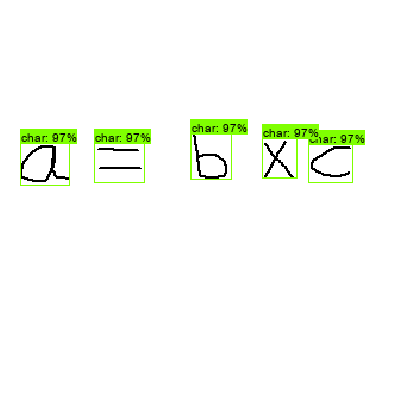

Generated XMLs
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>a</mi><mo>=</mo><mi>b</mi><mo>&#215;</mo><mi>c</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>a</mi><mo>=</mo><mi>b</mi><mo>&#215;</mo><mi>c</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>a</mi><mo>=</mo><mi>bxc</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>a</mi><mo>=</mo><mi>bxc</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>a</mi><mo>=</mo><mi>bXc</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>a</mi><mo>=</mo><mi>bXc</mi></mrow></math>

**********
-------------------------
Detecting Boxes for Image:  datasets/object_detection/evaluate/exp0030.png
Image shape:  (320, 320, 3)
***************
Box: 
left:  276.8107604980469  right:  302.25046157836914  top:  117.35064506530762  bottom  153.64160537719727
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 79.03 %
Symbol_id: 89 , Latex: \# , Confidence Score: 9.38 %
Symbol_id: 43 , Latex: g , Confidence Score: 5.02 %
Symbol_id: 88 , Latex: \& , Confidence Score: 2.92 %
Symbol_id: 90 , Latex: \% , Confidence Score: 2.27 %


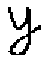

***************
Box: 
left:  18.98120880126953  right:  55.57942867279053  top:  113.63329887390137  bottom  148.81891250610352
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 83.54 %
Symbol_id: 25 , Latex: Z , Confidence Score: 15.99 %


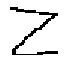

***************
Box: 
left:  212.36135482788086  right:  246.8006134033203  top:  112.35795974731445  bottom  146.02126121520996
CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 99.86 %


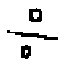

***************
Box: 
left:  151.5873622894287  right:  183.3692169189453  top:  115.90517997741699  bottom  149.99353408813477
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 83.52 %
Symbol_id: 59 , Latex: x , Confidence Score: 14.97 %
Symbol_id: 23 , Latex: X , Confidence Score: 1.44 %


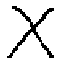

***************
Box: 
left:  88.14238548278809  right:  118.78169059753418  top:  113.9540958404541  bottom  146.32189750671387
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 98.06 %


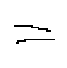

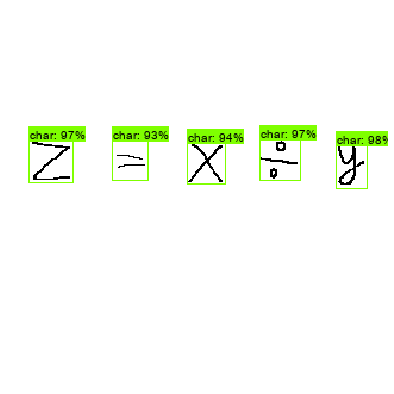

Generated XMLs
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>x</mi><mo>&#247;</mo><mi>y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>x</mi><mo>&#247;</mo><mi>y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>x</mi><mo>&#247;</mo><mi>Y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>x</mi><mo>&#247;</mo><mi>Y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>X</mi><mo>&#247;</mo><mi>y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>X</mi><mo>&#247;</mo><mi>y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>X</mi><mo>&#247;</mo><mi>Y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>X</mi><mo>&#247;</mo><mi>Y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>x</mi><mo>&#247;</mo><mi>y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>x</mi><mo>&#247;</mo><mi>y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>x</mi><mo>&#247;</mo><mi>Y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>x</mi><mo>&#247;</mo><mi>Y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>X</mi><mo>&#247;</mo><mi>y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>X</mi><mo>&#247;</mo><mi>y</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>X</mi><mo>&#247;</mo><mi>Y</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>X</mi><mo>&#247;</mo><mi>Y</mi></mrow></math>

**********
-------------------------
Detecting Boxes for Image:  datasets/object_detection/evaluate/exp0035.png
Image shape:  (320, 320, 3)
***************
Box: 
left:  30.268211364746094  right:  49.52845096588135  top:  111.52939796447754  bottom  148.836088180542
CNN/ANN Predictions:
Symbol_id: 1 , Latex: B , Confidence Score: 98.9 %


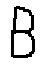

***************
Box: 
left:  73.0113172531128  right:  106.86600685119629  top:  113.58922958374023  bottom  150.80995559692383
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 99.42 %


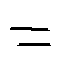

***************
Box: 
left:  226.45605087280273  right:  252.58251190185547  top:  108.83499145507812  bottom  140.3049373626709
CNN/ANN Predictions:
Symbol_id: 3 , Latex: D , Confidence Score: 98.0 %
Symbol_id: 51 , Latex: o , Confidence Score: 1.1 %


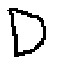

***************
Box: 
left:  120.15374183654785  right:  152.28909492492676  top:  110.05145072937012  bottom  142.37777709960938
CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 99.63 %


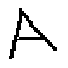

***************
Box: 
left:  164.56459045410156  right:  202.98128128051758  top:  108.49658012390137  bottom  144.1020393371582
CNN/ANN Predictions:
Symbol_id: 94 , Latex: \div , Confidence Score: 99.94 %


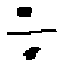

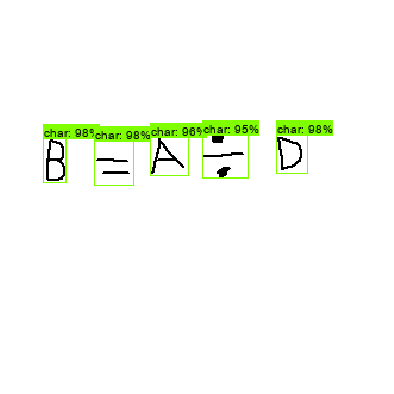

Generated XMLs
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>B</mi><mo>=</mo><mi>A</mi><mo>&#247;</mo><mi>D</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>B</mi><mo>=</mo><mi>A</mi><mo>&#247;</mo><mi>D</mi></mrow></math>

**********
-------------------------
Detecting Boxes for Image:  datasets/object_detection/evaluate/exp0039.png
Image shape:  (320, 320, 3)
***************
Box: 
left:  243.24983596801758  right:  277.6800346374512  top:  107.34728813171387  bottom  134.0103054046631
CNN/ANN Predictions:
Symbol_id: 92 , Latex: \times , Confidence Score: 99.89 %


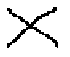

***************
Box: 
left:  62.09640026092529  right:  91.68543815612793  top:  101.64618492126465  bottom  133.9903736114502
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 98.7 %


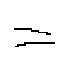

***************
Box: 
left:  4.227026104927063  right:  42.568068504333496  top:  104.87212181091309  bottom  134.06046867370605
CNN/ANN Predictions:
Symbol_id: 61 , Latex: z , Confidence Score: 73.72 %
Symbol_id: 25 , Latex: Z , Confidence Score: 24.56 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 1.2 %


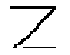

***************
Box: 
left:  113.47088813781738  right:  130.2757740020752  top:  105.17996788024902  bottom  141.09862327575684
CNN/ANN Predictions:
Symbol_id: 60 , Latex: y , Confidence Score: 26.99 %
Symbol_id: 97 , Latex: \forall , Confidence Score: 25.91 %
Symbol_id: 24 , Latex: Y , Confidence Score: 12.76 %
Symbol_id: 79 , Latex: > , Confidence Score: 7.6 %
Symbol_id: 87 , Latex: \} , Confidence Score: 6.94 %
Symbol_id: 70 , Latex: \mu , Confidence Score: 6.8 %
Symbol_id: 51 , Latex: o , Confidence Score: 5.38 %
Symbol_id: 72 , Latex: \rho , Confidence Score: 1.77 %
Symbol_id: 77 , Latex: \geq , Confidence Score: 1.73 %
Symbol_id: 98 , Latex: \exists , Confidence Score: 1.13 %


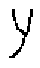

***************
Box: 
left:  173.57954025268555  right:  207.4458885192871  top:  105.87851524353027  bottom  137.18904495239258
CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 81.27 %
Symbol_id: 59 , Latex: x , Confidence Score: 6.4 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.48 %
Symbol_id: 61 , Latex: z , Confidence Score: 2.42 %
Symbol_id: 63 , Latex: \gamma , Confidence Score: 1.51 %


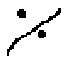

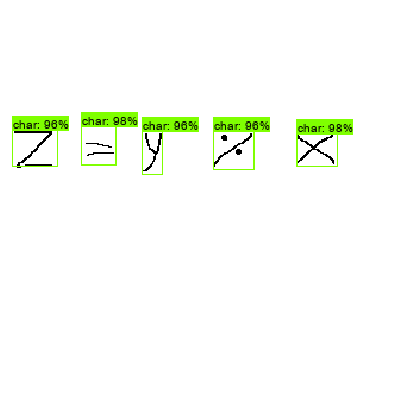

Generated XMLs
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>y</mi><mo>%</mo><mi>x</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>y</mi><mo>%</mo><mi>x</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>y</mi><mo>%</mo><mi>X</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>y</mi><mo>%</mo><mi>X</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>Y</mi><mo>%</mo><mi>x</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>Y</mi><mo>%</mo><mi>x</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>Y</mi><mo>%</mo><mi>X</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>z</mi><mo>=</mo><mi>Y</mi><mo>%</mo><mi>X</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>y</mi><mo>%</mo><mi>x</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>y</mi><mo>%</mo><mi>x</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>y</mi><mo>%</mo><mi>X</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>y</mi><mo>%</mo><mi>X</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>Y</mi><mo>%</mo><mi>x</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>Y</mi><mo>%</mo><mi>x</mi></mrow></math>

**********
('<math '
 'xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>Y</mi><mo>%</mo><mi>X</mi></mrow></math>')


<math xmlns="http://www.w3.org/1998/Math/MathML"><mrow><mi>Z</mi><mo>=</mo><mi>Y</mi><mo>%</mo><mi>X</mi></mrow></math>

**********
-------------------------
Detecting Boxes for Image:  datasets/object_detection/evaluate/exp0042.png
Image shape:  (320, 320, 3)
***************
Box: 
left:  13.2082200050354  right:  55.59993267059326  top:  90.39080619812012  bottom  121.66057586669922
CNN/ANN Predictions:
Symbol_id: 69 , Latex: \lambda , Confidence Score: 98.53 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 1.07 %


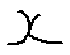

***************
Box: 
left:  175.9267234802246  right:  204.41461563110352  top:  87.92657852172852  bottom  116.02828979492188
CNN/ANN Predictions:
Symbol_id: 84 , Latex: + , Confidence Score: 96.97 %
Symbol_id: 96 , Latex: \perp , Confidence Score: 3.01 %


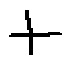

***************
Box: 
left:  217.89793014526367  right:  245.28398513793945  top:  89.97403144836426  bottom  115.60076713562012
CNN/ANN Predictions:
Symbol_id: 25 , Latex: Z , Confidence Score: 70.55 %
Symbol_id: 61 , Latex: z , Confidence Score: 26.28 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 3.1 %


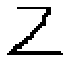

***************
Box: 
left:  126.76068305969238  right:  157.14746475219727  top:  89.87187385559082  bottom  126.12080574035645
CNN/ANN Predictions:
Symbol_id: 63 , Latex: \gamma , Confidence Score: 95.11 %
Symbol_id: 60 , Latex: y , Confidence Score: 3.04 %
Symbol_id: 93 , Latex: \ast , Confidence Score: 1.18 %


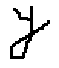

***************
Box: 
left:  81.64422035217285  right:  111.7056655883789  top:  89.2601203918457  bottom  123.43378067016602
CNN/ANN Predictions:
Symbol_id: 90 , Latex: \% , Confidence Score: 99.93 %


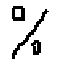

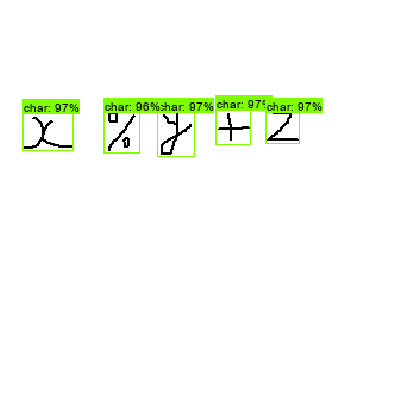

Generated XMLs
-------------------------
Detecting Boxes for Image:  datasets/object_detection/evaluate/exp0053.png
Image shape:  (320, 320, 3)
***************
Box: 
left:  27.242963314056396  right:  58.65066051483154  top:  109.55855369567871  bottom  145.4569435119629
CNN/ANN Predictions:
Symbol_id: 0 , Latex: A , Confidence Score: 95.86 %
Symbol_id: 65 , Latex: \Delta , Confidence Score: 3.39 %


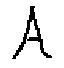

***************
Box: 
left:  140.7285976409912  right:  170.33119201660156  top:  108.65496635437012  bottom  142.70156860351562
CNN/ANN Predictions:
Symbol_id: 91 , Latex: \cup , Confidence Score: 87.95 %
Symbol_id: 56 , Latex: u , Confidence Score: 8.7 %
Symbol_id: 20 , Latex: U , Confidence Score: 2.32 %


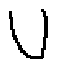

***************
Box: 
left:  252.79394149780273  right:  274.809513092041  top:  107.59018898010254  bottom  141.1984920501709
CNN/ANN Predictions:
Symbol_id: 76 , Latex: \leq , Confidence Score: 66.88 %
Symbol_id: 82 , Latex: \subseteq , Confidence Score: 8.2 %
Symbol_id: 28 , Latex: 2 , Confidence Score: 6.06 %
Symbol_id: 99 , Latex: [ , Confidence Score: 4.81 %
Symbol_id: 39 , Latex: c , Confidence Score: 4.58 %
Symbol_id: 94 , Latex: \div , Confidence Score: 3.91 %
Symbol_id: 45 , Latex: i , Confidence Score: 1.36 %
Symbol_id: 25 , Latex: Z , Confidence Score: 1.13 %


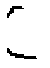

***************
Box: 
left:  198.0530548095703  right:  226.97725296020508  top:  108.17239761352539  bottom  138.82519721984863
CNN/ANN Predictions:
Symbol_id: 95 , Latex: \cap , Confidence Score: 99.52 %


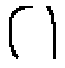

***************
Box: 
left:  78.21629524230957  right:  106.6722297668457  top:  112.37457275390625  bottom  142.4365234375
CNN/ANN Predictions:
Symbol_id: 104 , Latex: = , Confidence Score: 99.44 %


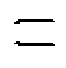

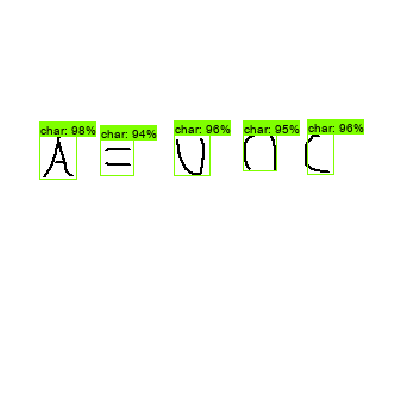

Generated XMLs


In [15]:
for image_path in image_paths:
    image_path = image_path.replace("\\", "/")
    im_name = image_path.split("/")[-1]
    image = Image.open(image_path)

    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = np.asarray(image)
    if len(image_np.shape) < 3:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_GRAY2RGB)
    else:
    	image_np = cv2.cvtColor(image_np, cv2.COLOR_RGBA2RGB)
    print('-'*25)
    print('Detecting Boxes for Image: ', image_path)
    
    print('Image shape: ', image_np.shape)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)

    # crop image and display
    im_width, im_height = image.size
    cropped_images = []
    box_syms = []
    for i in range(output_dict['num_detections']):
        if output_dict['detection_scores'][i] > 0.8:
            vis_util.visualize_boxes_and_labels_on_image_array(
                image_np,
                np.array([output_dict['detection_boxes'][i]]),
                np.array([output_dict['detection_classes'][i]]),
                np.array([output_dict['detection_scores'][i]]),
                category_index,
                instance_masks=output_dict.get('detection_masks'),
                use_normalized_coordinates=True,
                line_thickness=1)
            (ymin, xmin, ymax, xmax) = output_dict['detection_boxes'][i]
            (left, right, top, bottom) = (xmin * im_width,
                                          xmax * im_width,
                                          ymin * im_height,
                                          ymax * im_height)
            print('*'*15)
            print("Box: ")
            # print("ymin: ", ymin," xmin: ", xmin, " ymax: ", ymax," xmax ", xmax)
            print("left: ", left," right: ", right," top: ", top," bottom ", bottom)
            # print("Top left point: (",int(left),", ",int(top),") and Bottom right point: (",int(right),", ",int(bottom),")")
            
            cropped_image = image.crop((left, top, right, bottom))
            
            # Predict label for cropped image with CNN
            c_im = np.asarray(cropped_image)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_BGRA2RGBA)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2RGB)
            c_im = cv2.cvtColor(c_im, cv2.COLOR_RGBA2GRAY)
            c_im = cv2.resize(c_im, (32,32))
            c_im = c_im / 255.0
            # Symbol Prediction
            # CNN
            c_im = np.resize(c_im, (1, 1, 32, 32))
            res = cnn.predict(c_im)
            res = res.flatten()
            lbls = one_hot_encode_to_char_list(res, threshold=0.01, get_max = False)
            print("CNN/ANN Predictions:")
            syms = []
            for j in lbls:
                symbols_row = symbols[symbols['new_id'] == j[0]][['latex', 'old_symbol', 'new_id']]
                latex, old_symbol, new_id = symbols_row.iloc[0].to_list()
                conf_score = round(j[1] * 100, 2)
                syms.append((get_symbol_from_id(new_id), conf_score))
                print('Symbol_id:', new_id, ', Latex:', latex, ', Confidence Score:', conf_score, '%')
            box_syms.append(({
                'x1':left,
                'x2':right,
                'y1':top,
                'y2':bottom
            },
            syms))
            plt.figure(figsize=(1,1))
            plt.axis('off')
            temp_ = np.asarray(cropped_image)
            plt.imshow(temp_)
            plt.show()
            cropped_images.append(np.asarray(cropped_image))
    plt.figure(figsize=(7,7))
    plt.axis('off')
    temp_ = cv2.resize(image_np, (int(im_width), int(im_height)))
    plt.imshow(temp_)
    plt.show()
    
    # Predict xml
    box_syms = sorted(box_syms, key=lambda x: x[0]['x1'])
    sym_preds = [i[1] for i in box_syms]
    identified_syms = get_symbols(sym_preds)
    eqns = generate_eqns(identified_syms)
    predicted_eqns = []
    for i in eqns:
        try:
            tokens = lexer.generate_tokens(list(i))
            tree = parser.generate_tree(tokens)
            xml_tree = codegen.gen_mathml(tree)
            xml = ET.tostring(xml_tree, pretty_print=False).decode('utf-8')
            predicted_eqns.append(xml)
        except:
            pass
            # print(f'Equation {i} failed')
    print('Generated XMLs')
    for e in predicted_eqns:
        pprint(e)
        display(Markdown(e))
        print('*'*10)

---
## Result:


xml code is generated correctly for 6 out of 10 images

---